In [1]:
from matplotlib import pyplot as plt
import numpy as np
import cv2 as cv
from PIL import Image
from skimage.io import  imread
from scipy.fftpack import dct, idct
import os

# Image Sampling

Image sampling involves taking the value of the image at regular spatial intervals. The length of the intervals defines the spatial resolution of the image. While decreasing the sampling on the image’s spatial resolution, it is clear that the image is no longer clear. Lots of information is lost, and the digital image cannot fully represent the analog object.

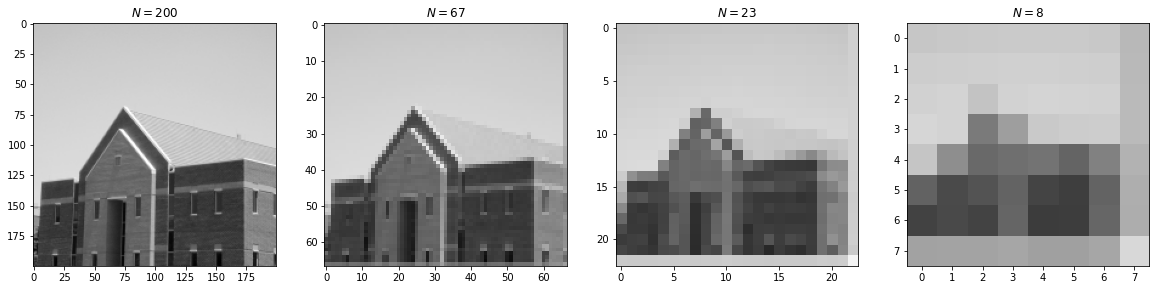

In [3]:
img = imread('building.png')

from skimage.transform import downscale_local_mean
factors = 3**np.arange(1, 5)

figure, axis = plt.subplots(1, len(factors), figsize=(20, 6))
for factor, ax in zip(factors, axis):
    image = downscale_local_mean(img, 
                 factors=(factor, factor, 1)).astype(int)
    ax.imshow(image)
    ax.set_title('$N={}$'.format(image.shape[0]))

#  Image quantization

Image quantization involves discretizing the intensity values of the analog image. It is a lossy compression technique achieved by compressing a range of values to a single quantum value As we increase the number of discrete values representing the image intensity values in the image, the better we can represent an analog object into a digital image

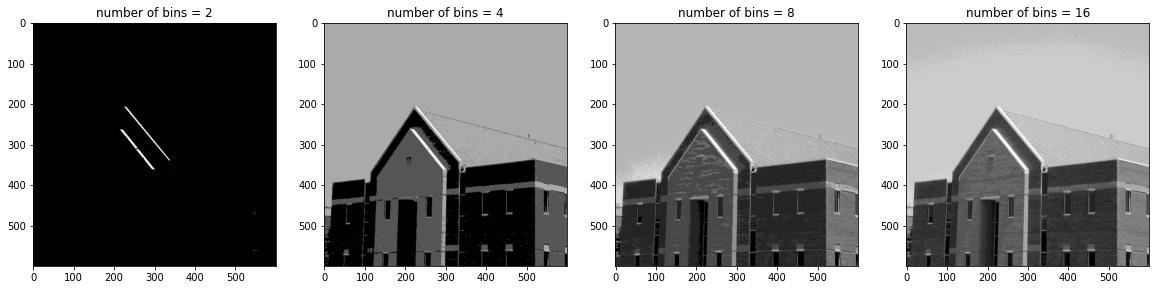

In [4]:
img = imread('building.png')

factors = 2**np.arange(1, 5)
figure, axis = plt.subplots(1, len(factors), figsize=(20, 6))

afterbin_images = []
for k, ax in zip(factors, axis):
    bins = np.linspace(0, img.max(), k)
    image = np.digitize(img, bins)
    image = (np.vectorize(bins.tolist().__getitem__)
                         (image-1).astype('int'))
    afterbin_images.append(image.astype('uint8'))
    ax.imshow(image)
    ax.set_title('number of bins = {}'.format(k))

In [5]:
k2 = Image.fromarray(afterbin_images[0].astype('uint8'))
k2.save('k2.png')

k4 = Image.fromarray(afterbin_images[1].astype('uint8'))
k4.save('k4.png')

k8 = Image.fromarray(afterbin_images[2].astype('uint8'))
k8.save('k8.png')

k16 = Image.fromarray(afterbin_images[3].astype('uint8'))
k16.save('k16.png')

In [32]:
#For further quality analysis of image size compression rate, and mean squared error
def size_compresssion(imageA,imageB):
    file1Size = float(os.stat(imageA).st_size)
    file2Size = float(os.stat(imageB).st_size)
    print('compression rate: {}'.format(file2Size/file1Size))


def mse(imageA, imageB):
	# the 'Mean Squared Error' between the two images is the sum of the squared difference between the two images;
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2) 
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err


def normalized_mse(imageA, imageB):
    normalizedA = cv.normalize(imageA, imageA, 0, 255, cv.NORM_MINMAX)
    normalizedB = cv.normalize(imageB, imageB, 0, 255, cv.NORM_MINMAX)
    print(mse(normalizedA,normalizedB))

# Discrete Cosine Transformation (DCT)

Divide image into 8x8 pixel blocks

In [11]:
img = cv.imread('building.png',0)

In [12]:
def apply_histogram(block):
    h, b = np.histogram(block.flatten(), 256, normed=True)
    cdf = h.cumsum()
    cdf = 255 * cdf / cdf[-1]
    return np.interp(block.flatten(), b[:-1], cdf).reshape(block.shape)

block_img = np.zeros((600,600))
im_h, im_w = img.shape[:2]
bl_h, bl_w = 8, 8

for row in np.arange(im_h - bl_h + 1, step=bl_h):
    for col in np.arange(im_w - bl_w + 1, step=bl_w):
        block_img[row:row+bl_h, col:col+bl_w] = apply_histogram(img[row:row+bl_h, col:col+bl_w])

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


For each block, compute 2D DCT and zero-out all but the 10 most significant values. The most significant values are the first elements, i.e. the upper-left corner of 2D DCT

In [14]:
def dct2(a):
    return dct(dct(a.T, norm='ortho').T, norm='ortho')

def idct2(a):
    return idct(idct(a.T, norm='ortho').T, norm='ortho')

In [15]:
imF = dct2(img)
#Make all the elemant zero except max n element in each row in numpy 2d-array
n_max = 10 
imF_= imF * (imF >= np.sort(imF, axis=1)[:,[-n_max]]).astype(float)

For each block, invert the DCT and reconstruct the original image by combining the blocks

(<AxesSubplot:title={'center':'After suppression'}>,
 Text(0.5, 1.0, 'After suppression'))

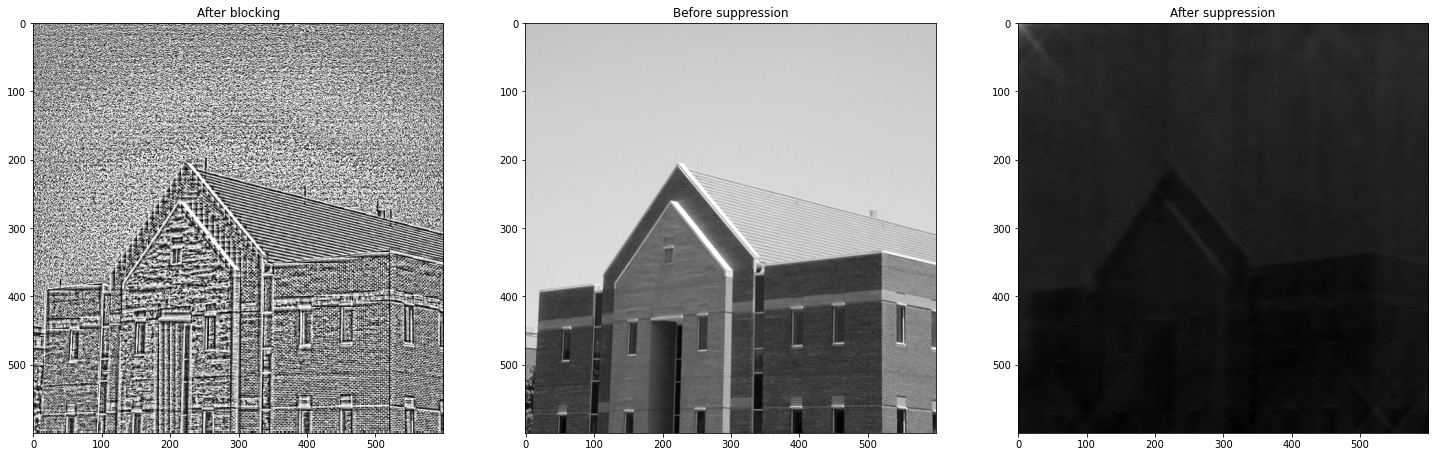

In [16]:
plt.figure(figsize=(5*5, 5*5), constrained_layout=False)
plt.subplot(131), plt.imshow(block_img,"gray"), plt.title("After blocking")
plt.subplot(132), plt.imshow(idct2(imF),"gray"), plt.title("Before suppression")
plt.subplot(133), plt.imshow(idct2(imF_),"gray"), plt.title("After suppression")

# Store image by using run-length encoding (RLE)

In [17]:
img = cv.imread('building.png',1)

(600, 600, 3)

In [18]:
#https://www.kaggle.com/leahscherschel/run-length-encoding
def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==0)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [33]:
enco_img = rle_encoding(img.astype('uint8'))
#From 1D to store into image format
rle_arr = np.array(enco_img, dtype=np.uint8)
rle = Image.fromarray(rle_arr)
rle.save('rle.png')